In [1]:
# Core utilities moved to fire_model package
import numpy as np
import matplotlib.pyplot as plt
from fire_model.ca import FireEnv, FireState, CAFireModel
from fire_model.boundary import (
    FireBoundary,
    between_boundaries_mask,
    candidates_from_mask,
    extract_fire_boundary,
    plot_fire_boundary,
)
from fire_model.harmonic import (
    HarmonicStripMap,
    BoundaryMap,
    build_harmonic_strip_map_uniform,
    plot_strip_map,
    sd_to_xy_theta,
    build_boundary_map,
    plot_boundary_correspondence,
)
from fire_model.bo import (
    RetardantDropBayesOpt,
    SearchGridProjector,
    TiedXYFiMatern,
    expected_improvement,
)

import fire_model.bo as bo

### Environment Set-Up

In [2]:
# Grid / domain
nx = ny = 100
domain_km = 5

# Time discretisation (used for indexing time-varying wind and for FireState.t)
dt_s = 5.0

# Fire physics parameters
burn_time_s0 = 15 * 60         # how long a cell stays "burning" after ignition (seconds)
ros_mps = 0.2                 # baseline ROS (m/s)

# Retardant parameters
retardant_half_life_s = 2400.0 # seconds (e.g., 40 minutes)
retardant_k = 1.25             # attenuation strength exp(-k * retardant)

# Spatial maps
xs = np.linspace(-1.0, 1.0, nx)[:, None]
ys = np.linspace(-1.0, 1.0, ny)[None, :]
fuel = 0.7 + 0.9 * np.exp(-3.0 * (xs**2 + ys**2))
value = 1.0 + 3.0 * np.exp(-4.0 * ((xs - 0.2) ** 2 + (ys + 0.1) ** 2))

# Constant wind: mild south-westerly
wind=np.zeros((nx, ny, 2), dtype=float)
wind[..., 0] = -3
wind[..., 1] = -3

env = FireEnv(
    grid_size=(nx, ny),
    domain_km=domain_km,
    wind=wind,
    fuel=fuel,
    value=value,
    dt_s=dt_s,
    burn_time_s0=burn_time_s0,
    retardant_half_life_s=retardant_half_life_s,
    retardant_k=retardant_k,
    ros_mps=ros_mps,
    # wind_coeff is unused by the Finsler model, but can exist in the env
    wind_coeff=0.6,
    diag=True,
)

ca_model = CAFireModel(env,seed=42)

### Ignition and Search Domain

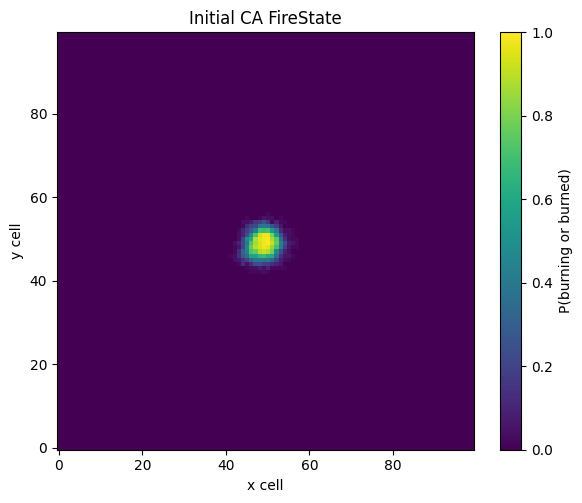

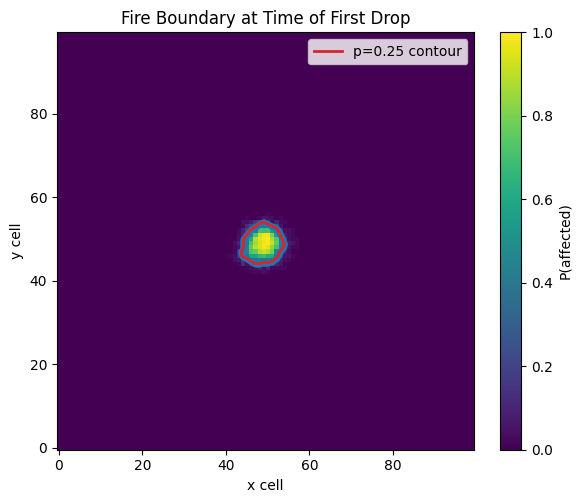

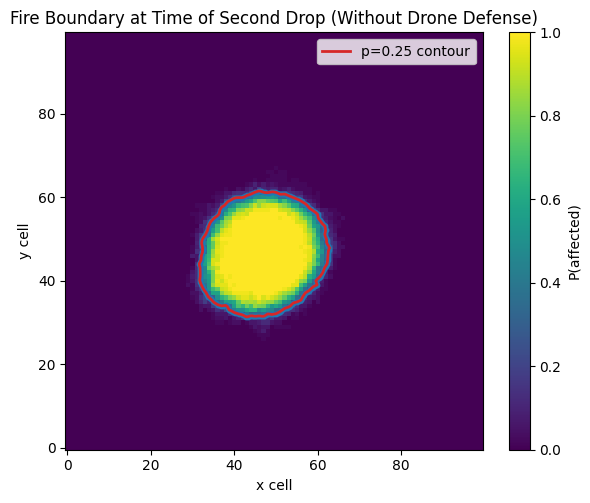

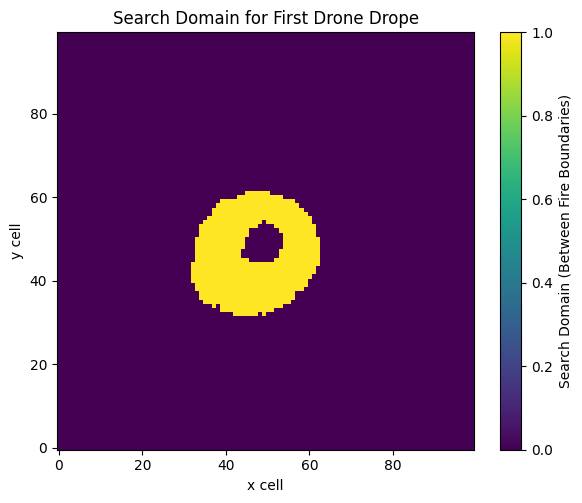

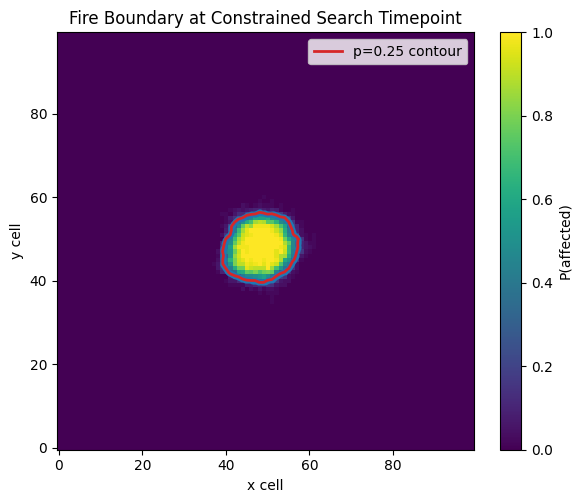

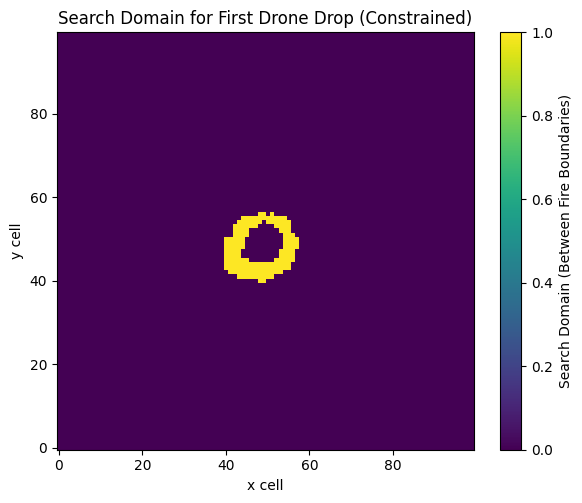

In [3]:
# Ignition and time until drones reach the fire
ignition_center = (nx // 2, ny // 2)
ignition_radius_km = 0.01
time_to_first_drop = 60.0  # 1 minute to response
time_to_second_drop = 180.0 # 2 minutes later 
search_space_time = (time_to_second_drop - time_to_first_drop)//3

# Initial Evolution
init_firestate_ca = ca_model.simulate_from_ignition(
    center=ignition_center,
    radius_km=ignition_radius_km,
    n_sims=50,
    T=time_to_first_drop
)

ca_model.plot_firestate(init_firestate_ca,title="Initial CA FireState")

# Visualising the boundary
init_boundary = extract_fire_boundary(
    init_firestate_ca,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)

plot_fire_boundary(
    init_firestate_ca,
    init_boundary,
    field="affected",
    title="Fire Boundary at Time of First Drop"
)

# Visualising the search domain
second_firestate_ca = ca_model.simulate_from_firestate(
    init_firestate=init_firestate_ca,
    T=time_to_second_drop - time_to_first_drop, # assumes we want to search the whole space between first & second drop (smaller might be better in practice)
    n_sims=50,
)

second_boundary = extract_fire_boundary(
    second_firestate_ca,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)

plot_fire_boundary(
    second_firestate_ca,
    second_boundary,
    field="affected",
    title="Fire Boundary at Time of Second Drop (Without Drone Defense)"
)

between_boundaries_mask = ca_model.discretise_between_boundaries(init_boundary, second_boundary)

ca_model.plot_search_domain(between_boundaries_mask,title="Search Domain for First Drone Drope")

# Extra constrained search space

constrained_firestate_ca = ca_model.simulate_from_firestate(
    init_firestate=init_firestate_ca,
    T=search_space_time, # assumes we want to search the whole space between first & second drop (smaller might be better in practice)
    n_sims=50,
)

constrained_boundary = extract_fire_boundary(
    constrained_firestate_ca,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)

plot_fire_boundary(
    constrained_firestate_ca,
    constrained_boundary,
    field="affected",
    title="Fire Boundary at Constrained Search Timepoint"
)

between_boundaries_mask = ca_model.discretise_between_boundaries(init_boundary, constrained_boundary)

ca_model.plot_search_domain(between_boundaries_mask,title="Search Domain for First Drone Drop (Constrained)")

### Bayesian Optimisation Set-Up

In [4]:
from fire_model.bo import RetardantDropBayesOpt

constrained_search_time = (time_to_second_drop - time_to_first_drop)//3

drop_opt = RetardantDropBayesOpt(
    fire_model=ca_model,
    init_firestate=init_firestate_ca,
    n_drones=3,
    evolution_time_s=time_to_second_drop-time_to_first_drop,
    search_grid_evolution_time_s=constrained_search_time,
    n_sims=50,
    fire_boundary_probability=0.5,
)

### Bayesian Optimisation (Random Initialisation)

In [ ]:
search_mask, coords = drop_opt.setup_search_grid(K=300, boundary_field="affected")
best_theta, best_params, best_value, (X, y), y_nexts, y_bests = drop_opt.run_bayes_opt(
    n_init=10,
    n_iters=100,
    n_candidates=3000,
    xi=0.01, 
    verbose=True,
    init_strategy="random",
    print_every=10
)

[BO] init: n_init=10, dim=9, n_cells=223
[BO] init: best_y=1.50998, mean_y=1.68245, std_y=0.0951845
[BO] iter 001/100 | y_next=1.46779 | best_y=1.46779 (improved) | EI_max=0.00224 | mu=1.64782 | std=0.0932
      proposed (x,y,phi) per drone:
      [[40.         52.          4.8525526 ]
 [49.         56.          3.7914905 ]
 [50.         39.          3.99305889]]
      gp.kernel_ = 0.455**2 * TiedXYFiMatern(lx=0.00116, ly=125, lphi=8.83, nu=2.5) + WhiteKernel(noise_level=0.793)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 002/100 | y_next=1.58442 | best_y=1.46779 (no-improve) | EI_max=0.00131 | mu=1.66293 | std=0.11
      proposed (x,y,phi) per drone:
      [[43.         55.          2.7229518 ]
 [56.         44.          4.9466099 ]
 [56.         44.          5.18658173]]
      gp.kernel_ = 0.035**2 * TiedXYFiMatern(lx=165, ly=892, lphi=0.001, nu=2.5) + WhiteKernel(noise_level=0.999)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 003/100 | y_next=1.69597 | best_y=1.46779 (no-improve) | EI_max=0.00242 | mu=1.496 | std=0.0349
      proposed (x,y,phi) per drone:
      [[40.         52.          4.81494656]
 [49.         56.          4.89578803]
 [50.         39.          0.46983553]]
      gp.kernel_ = 0.898**2 * TiedXYFiMatern(lx=0.00122, ly=1e+03, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.0715)
[BO] iter 004/100 | y_next=1.72312 | best_y=1.46779 (no-improve) | EI_max=0.00102 | mu=1.65944 | std=0.104
      proposed (x,y,phi) per drone:
      [[40.         52.          2.61018386]
 [50.         39.          4.81943678]
 [56.         44.          5.13644973]]
      gp.kernel_ = 0.149**2 * TiedXYFiMatern(lx=0.559, ly=0.0117, lphi=0.013, nu=2.5) + WhiteKernel(noise_level=0.978)
[BO] iter 005/100 | y_next=1.66474 | best_y=1.46779 (no-improve) | EI_max=0.000776 | mu=1.66398 | std=0.101
      proposed (x,y,phi) per drone:
      [[40.         41.          2.16224925]
 [41.         40.          4.62494776]

/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 007/100 | y_next=1.6157 | best_y=1.46779 (no-improve) | EI_max=0.00329 | mu=1.56775 | std=0.0812
      proposed (x,y,phi) per drone:
      [[40.         52.          3.2433018 ]
 [49.         39.          3.82982027]
 [50.         39.          3.51207193]]
      gp.kernel_ = 0.968**2 * TiedXYFiMatern(lx=0.026, ly=1e+03, lphi=1.37, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 008/100 | y_next=1.58079 | best_y=1.46779 (no-improve) | EI_max=0.0035 | mu=1.56303 | std=0.0798
      proposed (x,y,phi) per drone:
      [[40.         52.          0.24267105]
 [50.         39.          3.56210693]
 [50.         56.          4.25496599]]
      gp.kernel_ = 0.963**2 * TiedXYFiMatern(lx=0.0264, ly=1e+03, lphi=1.24, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 009/100 | y_next=1.58782 | best_y=1.46779 (no-improve) | EI_max=0.00357 | mu=1.55618 | std=0.0764
      proposed (x,y,phi) per drone:
      [[38.         44.          5.5825088 ]
 [48.         41.          3.63750711]
 [50.         56.          3.4650035 ]]
      gp.kernel_ = 0.946**2 * TiedXYFiMatern(lx=0.0262, ly=1e+03, lphi=1.22, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 010/100 | y_next=1.69338 | best_y=1.46779 (no-improve) | EI_max=0.00314 | mu=1.52494 | std=0.056
      proposed (x,y,phi) per drone:
      [[40.         52.          4.48179575]
 [50.         39.          4.10004718]
 [50.         39.          4.32187555]]
      gp.kernel_ = 0.935**2 * TiedXYFiMatern(lx=0.0241, ly=1e+03, lphi=1.21, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 011/100 | y_next=1.46899 | best_y=1.46779 (no-improve) | EI_max=0.000659 | mu=1.63486 | std=0.0867
      proposed (x,y,phi) per drone:
      [[40.         52.          5.26004738]
 [49.         44.          2.00342497]
 [50.         56.          5.77126101]]
      gp.kernel_ = 0.98**2 * TiedXYFiMatern(lx=0.00578, ly=46.7, lphi=1.19, nu=2.5) + WhiteKernel(noise_level=8.81e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 012/100 | y_next=1.7783 | best_y=1.46779 (no-improve) | EI_max=0.00148 | mu=1.59774 | std=0.0821
      proposed (x,y,phi) per drone:
      [[40.         41.          0.34397962]
 [50.         56.          2.20252574]
 [50.         56.          4.91374912]]
      gp.kernel_ = 0.982**2 * TiedXYFiMatern(lx=0.00649, ly=1e+03, lphi=1.37, nu=2.5) + WhiteKernel(noise_level=0.00153)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 013/100 | y_next=1.59429 | best_y=1.46779 (no-improve) | EI_max=0.00163 | mu=1.62559 | std=0.0968
      proposed (x,y,phi) per drone:
      [[43.         55.          4.53371381]
 [50.         56.          3.30686572]
 [52.         40.          4.49067838]]
      gp.kernel_ = 0.997**2 * TiedXYFiMatern(lx=1e+03, ly=0.0226, lphi=0.664, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 014/100 | y_next=1.68657 | best_y=1.46779 (no-improve) | EI_max=0.00322 | mu=1.57272 | std=0.0835
      proposed (x,y,phi) per drone:
      [[40.         52.          4.54819757]
 [46.         56.          3.12960609]
 [50.         39.          4.45249318]]
      gp.kernel_ = 0.993**2 * TiedXYFiMatern(lx=543, ly=0.0259, lphi=0.698, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 015/100 | y_next=1.67943 | best_y=1.46779 (no-improve) | EI_max=0.00224 | mu=1.59427 | std=0.0875
      proposed (x,y,phi) per drone:
      [[40.         52.          3.71253339]
 [49.         39.          2.18288596]
 [50.         39.          5.11594244]]
      gp.kernel_ = 0.46**2 * TiedXYFiMatern(lx=0.001, ly=1e+03, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.749)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 016/100 | y_next=1.70994 | best_y=1.46779 (no-improve) | EI_max=0.000816 | mu=1.64403 | std=0.0936
      proposed (x,y,phi) per drone:
      [[40.         52.          4.98369566]
 [41.         40.          1.3785659 ]
 [43.         55.          5.96944878]]
      gp.kernel_ = 0.999**2 * TiedXYFiMatern(lx=1e+03, ly=0.0221, lphi=0.421, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 017/100 | y_next=1.84513 | best_y=1.46779 (no-improve) | EI_max=0.000511 | mu=1.6576 | std=0.0926
      proposed (x,y,phi) per drone:
      [[38.         44.          2.37633049]
 [38.         44.          3.24574274]
 [43.         39.          1.46631213]]
      gp.kernel_ = 1**2 * TiedXYFiMatern(lx=4.68, ly=0.00143, lphi=0.00421, nu=2.5) + WhiteKernel(noise_level=1.05e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 018/100 | y_next=1.72868 | best_y=1.46779 (no-improve) | EI_max=0.00168 | mu=1.61178 | std=0.0908
      proposed (x,y,phi) per drone:
      [[40.         52.          0.85045177]
 [49.         55.          4.42307325]
 [50.         56.          2.37976949]]
      gp.kernel_ = 0.423**2 * TiedXYFiMatern(lx=0.001, ly=140, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.791)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 019/100 | y_next=1.70945 | best_y=1.46779 (no-improve) | EI_max=0.00137 | mu=1.62774 | std=0.0946
      proposed (x,y,phi) per drone:
      [[40.         52.          5.51633593]
 [50.         39.          3.01286735]
 [53.         55.          6.2433154 ]]
      gp.kernel_ = 1**2 * TiedXYFiMatern(lx=0.0223, ly=0.0722, lphi=1.17, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 020/100 | y_next=1.60006 | best_y=1.46779 (no-improve) | EI_max=0.00045 | mu=1.66831 | std=0.0952
      proposed (x,y,phi) per drone:
      [[43.         39.          3.06504495]
 [47.         56.          3.937667  ]
 [50.         39.          3.55892382]]
      gp.kernel_ = 0.0716**2 * TiedXYFiMatern(lx=0.0092, ly=0.148, lphi=0.0563, nu=2.5) + WhiteKernel(noise_level=0.995)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 021/100 | y_next=1.68191 | best_y=1.46779 (no-improve) | EI_max=0.000823 | mu=1.63862 | std=0.0914
      proposed (x,y,phi) per drone:
      [[41.         53.          6.05226318]
 [49.         56.          6.20546305]
 [50.         39.          2.37951275]]
      gp.kernel_ = 0.334**2 * TiedXYFiMatern(lx=0.0325, ly=451, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.884)
[BO] iter 022/100 | y_next=1.67514 | best_y=1.46779 (no-improve) | EI_max=0.000685 | mu=1.64256 | std=0.0905
      proposed (x,y,phi) per drone:
      [[40.         52.          5.230039  ]
 [48.         45.          0.37683583]
 [50.         56.          5.62658804]]
      gp.kernel_ = 0.312**2 * TiedXYFiMatern(lx=0.0324, ly=424, lphi=218, nu=2.5) + WhiteKernel(noise_level=0.9)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 023/100 | y_next=1.64453 | best_y=1.46779 (no-improve) | EI_max=0.000349 | mu=1.66681 | std=0.0914
      proposed (x,y,phi) per drone:
      [[39.         48.          2.29950992]
 [40.         52.          4.46072834]
 [52.         40.          4.58747108]]
      gp.kernel_ = 0.068**2 * TiedXYFiMatern(lx=0.001, ly=0.001, lphi=0.001, nu=2.5) + WhiteKernel(noise_level=0.995)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 024/100 | y_next=1.57763 | best_y=1.46779 (no-improve) | EI_max=0.000526 | mu=1.64544 | std=0.0881
      proposed (x,y,phi) per drone:
      [[40.         52.          4.40276363]
 [49.         39.          5.35929995]
 [50.         56.          3.78783046]]
      gp.kernel_ = 0.278**2 * TiedXYFiMatern(lx=0.031, ly=1e+03, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.919)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 025/100 | y_next=1.78847 | best_y=1.46779 (no-improve) | EI_max=0.000344 | mu=1.66353 | std=0.09
      proposed (x,y,phi) per drone:
      [[40.         52.          1.66530045]
 [46.         56.          5.04475681]
 [56.         44.          5.61557966]]
      gp.kernel_ = 0.0503**2 * TiedXYFiMatern(lx=0.001, ly=0.001, lphi=0.001, nu=2.5) + WhiteKernel(noise_level=0.997)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 026/100 | y_next=1.64241 | best_y=1.46779 (no-improve) | EI_max=0.000854 | mu=1.62644 | std=0.0867
      proposed (x,y,phi) per drone:
      [[40.         52.          0.83849311]
 [49.         45.          3.44590603]
 [50.         56.          3.4114416 ]]
      gp.kernel_ = 0.359**2 * TiedXYFiMatern(lx=0.001, ly=1e+03, lphi=586, nu=2.5) + WhiteKernel(noise_level=0.848)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 027/100 | y_next=1.66427 | best_y=1.46779 (no-improve) | EI_max=0.000758 | mu=1.62744 | std=0.0855
      proposed (x,y,phi) per drone:
      [[40.         52.          4.98553225]
 [49.         56.          3.2994589 ]
 [50.         39.          3.80698973]]
      gp.kernel_ = 0.357**2 * TiedXYFiMatern(lx=0.001, ly=325, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.849)
[BO] iter 028/100 | y_next=1.62976 | best_y=1.46779 (no-improve) | EI_max=0.00028 | mu=1.66636 | std=0.0887
      proposed (x,y,phi) per drone:
      [[44.         39.          2.56381011]
 [53.         55.          4.35113688]
 [56.         44.          3.45069661]]
      gp.kernel_ = 1**2 * TiedXYFiMatern(lx=0.075, ly=2.55, lphi=0.00183, nu=2.5) + WhiteKernel(noise_level=5.13e-05)
[BO] iter 029/100 | y_next=1.59183 | best_y=1.46779 (no-improve) | EI_max=0.000578 | mu=1.6355 | std=0.0853
      proposed (x,y,phi) per drone:
      [[39.         43.          5.45372683]
 [48.         56.          4.59584565]
 

/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 030/100 | y_next=1.59266 | best_y=1.46779 (no-improve) | EI_max=0.000504 | mu=1.63731 | std=0.0843
      proposed (x,y,phi) per drone:
      [[41.         40.          5.84879617]
 [48.         56.          2.3248144 ]
 [48.         56.          3.99636373]]
      gp.kernel_ = 0.422**2 * TiedXYFiMatern(lx=0.037, ly=225, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.839)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 031/100 | y_next=1.68443 | best_y=1.46779 (no-improve) | EI_max=0.000547 | mu=1.63364 | std=0.0839
      proposed (x,y,phi) per drone:
      [[43.         55.          4.8977234 ]
 [48.         39.          0.32548648]
 [49.         56.          2.07261408]]
      gp.kernel_ = 0.466**2 * TiedXYFiMatern(lx=0.0416, ly=1e+03, lphi=612, nu=2.5) + WhiteKernel(noise_level=0.819)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 032/100 | y_next=1.68711 | best_y=1.46779 (no-improve) | EI_max=0.000542 | mu=1.63188 | std=0.083
      proposed (x,y,phi) per drone:
      [[40.         41.          1.44105222]
 [49.         56.          0.87458563]
 [50.         56.          4.58160892]]
      gp.kernel_ = 0.317**2 * TiedXYFiMatern(lx=0.001, ly=1e+03, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.885)
[BO] iter 033/100 | y_next=1.77303 | best_y=1.46779 (no-improve) | EI_max=0.000442 | mu=1.6334 | std=0.0812
      proposed (x,y,phi) per drone:
      [[43.         39.          4.48073292]
 [50.         56.          2.99386312]
 [50.         56.          3.73417718]]
      gp.kernel_ = 0.483**2 * TiedXYFiMatern(lx=0.0463, ly=316, lphi=2.51, nu=2.5) + WhiteKernel(noise_level=0.781)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 034/100 | y_next=1.46638 | best_y=1.46638 (improved) | EI_max=0.000409 | mu=1.64262 | std=0.084
      proposed (x,y,phi) per drone:
      [[38.         44.          1.46062412]
 [48.         39.          3.58529121]
 [49.         55.          5.34007706]]
      gp.kernel_ = 0.358**2 * TiedXYFiMatern(lx=0.0274, ly=227, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.874)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 035/100 | y_next=1.80937 | best_y=1.46638 (no-improve) | EI_max=0.00035 | mu=1.66092 | std=0.0898
      proposed (x,y,phi) per drone:
      [[40.         52.          5.50623618]
 [50.         39.          1.96421623]
 [54.         54.          5.79422195]]
      gp.kernel_ = 0.0316**2 * TiedXYFiMatern(lx=0.0106, ly=1.52, lphi=0.0599, nu=2.5) + WhiteKernel(noise_level=0.999)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 036/100 | y_next=1.80107 | best_y=1.46638 (no-improve) | EI_max=0.000678 | mu=1.64295 | std=0.0911
      proposed (x,y,phi) per drone:
      [[38.         44.          1.16630353]
 [46.         39.          4.41174742]
 [53.         55.          5.68587671]]
      gp.kernel_ = 0.323**2 * TiedXYFiMatern(lx=135, ly=0.0101, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.899)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 037/100 | y_next=1.74061 | best_y=1.46638 (no-improve) | EI_max=0.000363 | mu=1.66719 | std=0.0926
      proposed (x,y,phi) per drone:
      [[40.         41.          3.87731296]
 [40.         52.          3.39059715]
 [50.         56.          5.55141502]]
      gp.kernel_ = 0.337**2 * TiedXYFiMatern(lx=0.001, ly=0.00425, lphi=0.001, nu=2.5) + WhiteKernel(noise_level=0.886)
[BO] iter 038/100 | y_next=1.92207 | best_y=1.46638 (no-improve) | EI_max=0.000334 | mu=1.66876 | std=0.0922
      proposed (x,y,phi) per drone:
      [[43.         55.          3.89339434]
 [43.         55.          5.72242231]
 [46.         56.          4.85784489]]
      gp.kernel_ = 0.806**2 * TiedXYFiMatern(lx=72, ly=0.0228, lphi=0.00369, nu=2.5) + WhiteKernel(noise_level=0.351)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 039/100 | y_next=1.71649 | best_y=1.46638 (no-improve) | EI_max=0.000456 | mu=1.67403 | std=0.0982
      proposed (x,y,phi) per drone:
      [[40.         41.          2.75673139]
 [43.         39.          0.09119054]
 [50.         39.          5.09523754]]
      gp.kernel_ = 0.133**2 * TiedXYFiMatern(lx=0.001, ly=0.001, lphi=0.001, nu=2.5) + WhiteKernel(noise_level=0.982)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 040/100 | y_next=1.76059 | best_y=1.46638 (no-improve) | EI_max=0.000418 | mu=1.6749 | std=0.0973
      proposed (x,y,phi) per drone:
      [[38.         44.          2.05428954]
 [43.         39.          2.94877576]
 [43.         55.          3.70545609]]
      gp.kernel_ = 0.0708**2 * TiedXYFiMatern(lx=0.001, ly=0.001, lphi=0.001, nu=2.5) + WhiteKernel(noise_level=0.995)
[BO] iter 041/100 | y_next=1.55488 | best_y=1.46638 (no-improve) | EI_max=0.000438 | mu=1.67175 | std=0.0967
      proposed (x,y,phi) per drone:
      [[43.         55.          6.00887301]
 [46.         56.          6.09170087]
 [56.         50.          2.81875952]]
      gp.kernel_ = 0.995**2 * TiedXYFiMatern(lx=13.6, ly=0.00108, lphi=0.187, nu=2.5) + WhiteKernel(noise_level=0.0102)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 042/100 | y_next=1.76562 | best_y=1.46638 (no-improve) | EI_max=0.000508 | mu=1.66785 | std=0.0972
      proposed (x,y,phi) per drone:
      [[41.         40.          5.72902186]
 [50.         56.          1.9099268 ]
 [50.         56.          4.44057625]]
      gp.kernel_ = 0.999**2 * TiedXYFiMatern(lx=26.7, ly=0.00111, lphi=0.259, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 043/100 | y_next=1.68201 | best_y=1.46638 (no-improve) | EI_max=0.00175 | mu=1.61242 | std=0.0925
      proposed (x,y,phi) per drone:
      [[39.         48.          4.74979936]
 [47.         56.          1.78568274]
 [48.         44.          2.58607439]]
      gp.kernel_ = 0.621**2 * TiedXYFiMatern(lx=0.0263, ly=117, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.686)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/si

[BO] iter 044/100 | y_next=1.72769 | best_y=1.46638 (no-improve) | EI_max=0.00038 | mu=1.6761 | std=0.0966
      proposed (x,y,phi) per drone:
      [[43.         55.          3.78290532]
 [49.         45.          0.14478198]
 [53.         55.          2.89675988]]
      gp.kernel_ = 0.0316**2 * TiedXYFiMatern(lx=1e+03, ly=0.001, lphi=0.001, nu=2.5) + WhiteKernel(noise_level=0.999)
[BO] iter 045/100 | y_next=1.81848 | best_y=1.46638 (no-improve) | EI_max=0.00035 | mu=1.67705 | std=0.0959
      proposed (x,y,phi) per drone:
      [[38.         44.          2.70139954]
 [39.         48.          4.85999062]
 [53.         55.          5.1707645 ]]
      gp.kernel_ = 0.049**2 * TiedXYFiMatern(lx=0.108, ly=0.249, lphi=0.0173, nu=2.5) + WhiteKernel(noise_level=0.998)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 046/100 | y_next=1.78042 | best_y=1.46638 (no-improve) | EI_max=0.000851 | mu=1.63351 | std=0.0903
      proposed (x,y,phi) per drone:
      [[40.         41.          4.93247335]
 [49.         39.          1.17040468]
 [50.         39.          1.71524082]]
      gp.kernel_ = 0.404**2 * TiedXYFiMatern(lx=0.00101, ly=1e+03, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.818)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 047/100 | y_next=1.73797 | best_y=1.46638 (no-improve) | EI_max=0.000334 | mu=1.68142 | std=0.097
      proposed (x,y,phi) per drone:
      [[41.         53.          4.70366832]
 [53.         55.          0.84396858]
 [56.         44.          5.71990546]]
      gp.kernel_ = 0.0316**2 * TiedXYFiMatern(lx=0.00281, ly=728, lphi=0.0236, nu=2.5) + WhiteKernel(noise_level=0.999)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 048/100 | y_next=1.73124 | best_y=1.46638 (no-improve) | EI_max=0.000309 | mu=1.68242 | std=0.0964
      proposed (x,y,phi) per drone:
      [[38.         44.          1.96276626]
 [55.         53.          0.07550194]
 [56.         44.          3.86660525]]
      gp.kernel_ = 1**2 * TiedXYFiMatern(lx=0.913, ly=134, lphi=0.00144, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 049/100 | y_next=1.64461 | best_y=1.46638 (no-improve) | EI_max=0.0031 | mu=1.56813 | std=0.081
      proposed (x,y,phi) per drone:
      [[40.         52.          4.75050717]
 [43.         55.          3.95630089]
 [50.         39.          4.0603624 ]]
      gp.kernel_ = 0.998**2 * TiedXYFiMatern(lx=16.5, ly=0.0147, lphi=0.288, nu=2.5) + WhiteKernel(noise_level=0.000325)
[BO] iter 050/100 | y_next=1.51288 | best_y=1.46638 (no-improve) | EI_max=0.00122 | mu=1.61888 | std=0.0894
      proposed (x,y,phi) per drone:
      [[38.         44.          1.5906681 ]
 [49.         39.          0.85215197]
 [

/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 066/100 | y_next=1.70649 | best_y=1.46638 (no-improve) | EI_max=0.000519 | mu=1.65566 | std=0.0926
      proposed (x,y,phi) per drone:
      [[40.         52.          4.67484126]
 [43.         39.          5.32201319]
 [46.         56.          3.65773821]]
      gp.kernel_ = 0.987**2 * TiedXYFiMatern(lx=0.045, ly=0.0178, lphi=0.411, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 067/100 | y_next=1.67804 | best_y=1.46638 (no-improve) | EI_max=0.000894 | mu=1.63622 | std=0.0922
      proposed (x,y,phi) per drone:
      [[40.         52.          5.07844589]
 [50.         56.          4.48484145]
 [52.         40.          3.85222781]]
      gp.kernel_ = 0.987**2 * TiedXYFiMatern(lx=0.0417, ly=0.0182, lphi=0.409, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 068/100 | y_next=1.73071 | best_y=1.46638 (no-improve) | EI_max=0.00089 | mu=1.61989 | std=0.0851
      proposed (x,y,phi) per drone:
      [[40.         52.          4.71247757]
 [48.         53.          2.83559339]
 [50.         39.          4.88118292]]
      gp.kernel_ = 0.534**2 * TiedXYFiMatern(lx=0.0387, ly=0.131, lphi=174, nu=2.5) + WhiteKernel(noise_level=0.738)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 069/100 | y_next=1.57185 | best_y=1.46638 (no-improve) | EI_max=0.000594 | mu=1.64764 | std=0.0912
      proposed (x,y,phi) per drone:
      [[42.         54.          4.80299479]
 [46.         56.          4.17663496]
 [52.         40.          4.51846431]]
      gp.kernel_ = 0.987**2 * TiedXYFiMatern(lx=0.0416, ly=0.0174, lphi=0.383, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 070/100 | y_next=1.73279 | best_y=1.46638 (no-improve) | EI_max=0.000448 | mu=1.65906 | std=0.0921
      proposed (x,y,phi) per drone:
      [[43.         55.          5.93980993]
 [48.         56.          6.1891751 ]
 [56.         49.          2.0061888 ]]
      gp.kernel_ = 0.986**2 * TiedXYFiMatern(lx=0.0415, ly=0.0207, lphi=0.407, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 071/100 | y_next=1.68185 | best_y=1.46638 (no-improve) | EI_max=0.000644 | mu=1.63792 | std=0.0883
      proposed (x,y,phi) per drone:
      [[46.         56.          5.94818147]
 [47.         56.          6.13510289]
 [56.         50.          3.27349771]]
      gp.kernel_ = 0.986**2 * TiedXYFiMatern(lx=0.0416, ly=0.0202, lphi=0.388, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 072/100 | y_next=1.60778 | best_y=1.46638 (no-improve) | EI_max=0.000391 | mu=1.65859 | std=0.0902
      proposed (x,y,phi) per drone:
      [[41.         40.          2.63985942]
 [50.         56.          3.7263284 ]
 [52.         40.          3.61853586]]
      gp.kernel_ = 0.987**2 * TiedXYFiMatern(lx=0.0408, ly=0.0197, lphi=0.377, nu=2.5) + WhiteKernel(noise_level=1.49e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 073/100 | y_next=1.77987 | best_y=1.46638 (no-improve) | EI_max=0.000377 | mu=1.6522 | std=0.0873
      proposed (x,y,phi) per drone:
      [[40.         52.          5.35518813]
 [45.         39.          4.10109334]
 [48.         56.          4.93457603]]
      gp.kernel_ = 0.987**2 * TiedXYFiMatern(lx=0.042, ly=0.0203, lphi=0.386, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 074/100 | y_next=1.62999 | best_y=1.46638 (no-improve) | EI_max=0.000358 | mu=1.66013 | std=0.0897
      proposed (x,y,phi) per drone:
      [[41.         40.          2.13458942]
 [46.         56.          5.0536431 ]
 [52.         40.          3.83953256]]
      gp.kernel_ = 0.988**2 * TiedXYFiMatern(lx=0.038, ly=0.0204, lphi=0.36, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 075/100 | y_next=1.69942 | best_y=1.46638 (no-improve) | EI_max=0.000422 | mu=1.64897 | std=0.0874
      proposed (x,y,phi) per drone:
      [[43.         39.          2.74792222]
 [43.         55.          3.82457491]
 [50.         39.          3.60272233]]
      gp.kernel_ = 0.988**2 * TiedXYFiMatern(lx=0.039, ly=0.0205, lphi=0.365, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 076/100 | y_next=1.6602 | best_y=1.46638 (no-improve) | EI_max=0.000556 | mu=1.64717 | std=0.0901
      proposed (x,y,phi) per drone:
      [[38.         44.          1.50541864]
 [50.         39.          3.39125975]
 [53.         55.          5.87032159]]
      gp.kernel_ = 0.989**2 * TiedXYFiMatern(lx=0.0372, ly=0.0205, lphi=0.363, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 077/100 | y_next=1.50646 | best_y=1.46638 (no-improve) | EI_max=0.000505 | mu=1.6452 | std=0.0881
      proposed (x,y,phi) per drone:
      [[40.         52.          5.22456192]
 [46.         56.          4.21119892]
 [53.         41.          4.43833498]]
      gp.kernel_ = 0.989**2 * TiedXYFiMatern(lx=0.0366, ly=0.0204, lphi=0.36, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 078/100 | y_next=1.57424 | best_y=1.46638 (no-improve) | EI_max=0.000441 | mu=1.65722 | std=0.0912
      proposed (x,y,phi) per drone:
      [[40.         52.          4.95262143]
 [53.         55.          4.24946804]
 [55.         43.          4.51603299]]
      gp.kernel_ = 0.986**2 * TiedXYFiMatern(lx=0.0355, ly=0.0242, lphi=0.387, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 079/100 | y_next=1.44834 | best_y=1.44834 (improved) | EI_max=0.000822 | mu=1.62534 | std=0.0863
      proposed (x,y,phi) per drone:
      [[42.         47.          0.39020856]
 [49.         54.          1.71905885]
 [50.         39.          4.75069563]]
      gp.kernel_ = 0.544**2 * TiedXYFiMatern(lx=0.0569, ly=0.157, lphi=539, nu=2.5) + WhiteKernel(noise_level=0.778)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 080/100 | y_next=1.5091 | best_y=1.44834 (no-improve) | EI_max=0.000442 | mu=1.64197 | std=0.0923
      proposed (x,y,phi) per drone:
      [[39.         48.          4.47065598]
 [46.         56.          4.08804423]
 [50.         39.          4.07444438]]
      gp.kernel_ = 0.989**2 * TiedXYFiMatern(lx=0.0399, ly=0.0248, lphi=0.387, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 081/100 | y_next=1.82559 | best_y=1.44834 (no-improve) | EI_max=0.00072 | mu=1.61052 | std=0.0859
      proposed (x,y,phi) per drone:
      [[40.         52.          5.25530493]
 [47.         56.          3.53388648]
 [52.         40.          3.68070446]]
      gp.kernel_ = 0.609**2 * TiedXYFiMatern(lx=0.0641, ly=0.152, lphi=5.54, nu=2.5) + WhiteKernel(noise_level=0.716)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 082/100 | y_next=1.63626 | best_y=1.44834 (no-improve) | EI_max=0.000781 | mu=1.6197 | std=0.0909
      proposed (x,y,phi) per drone:
      [[41.         40.          6.16139326]
 [48.         56.          1.54051793]
 [50.         39.          3.01036579]]
      gp.kernel_ = 0.53**2 * TiedXYFiMatern(lx=0.0639, ly=0.16, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.798)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 083/100 | y_next=1.55096 | best_y=1.44834 (no-improve) | EI_max=0.000554 | mu=1.63859 | std=0.0939
      proposed (x,y,phi) per drone:
      [[40.         52.          4.44193579]
 [46.         56.          4.66618613]
 [52.         40.          4.31082554]]
      gp.kernel_ = 0.989**2 * TiedXYFiMatern(lx=0.0318, ly=0.038, lphi=0.349, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 084/100 | y_next=1.61309 | best_y=1.44834 (no-improve) | EI_max=0.000503 | mu=1.64128 | std=0.0937
      proposed (x,y,phi) per drone:
      [[38.         44.          4.88143123]
 [43.         55.          4.13205742]
 [50.         39.          3.94600985]]
      gp.kernel_ = 0.987**2 * TiedXYFiMatern(lx=0.0278, ly=0.0438, lphi=0.396, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 085/100 | y_next=1.63848 | best_y=1.44834 (no-improve) | EI_max=0.000797 | mu=1.62557 | std=0.0937
      proposed (x,y,phi) per drone:
      [[40.         52.          4.29900672]
 [43.         55.          4.67758268]
 [49.         39.          5.23138911]]
      gp.kernel_ = 0.515**2 * TiedXYFiMatern(lx=19.5, ly=0.0569, lphi=0.857, nu=2.5) + WhiteKernel(noise_level=0.721)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 086/100 | y_next=1.74283 | best_y=1.44834 (no-improve) | EI_max=0.00048 | mu=1.63912 | std=0.0922
      proposed (x,y,phi) per drone:
      [[40.         52.          5.34853387]
 [49.         56.          4.30126323]
 [56.         44.          4.11837445]]
      gp.kernel_ = 0.986**2 * TiedXYFiMatern(lx=0.0282, ly=0.0449, lphi=0.4, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 087/100 | y_next=1.67584 | best_y=1.44834 (no-improve) | EI_max=0.00059 | mu=1.62078 | std=0.0875
      proposed (x,y,phi) per drone:
      [[40.         52.          2.19063349]
 [48.         56.          5.48627518]
 [50.         39.          5.45127323]]
      gp.kernel_ = 0.553**2 * TiedXYFiMatern(lx=0.0661, ly=0.157, lphi=838, nu=2.5) + WhiteKernel(noise_level=0.786)
[BO] iter 088/100 | y_next=1.78766 | best_y=1.44834 (no-improve) | EI_max=0.000701 | mu=1.6225 | std=0.0905
      proposed (x,y,phi) per drone:
      [[43.         39.          5.07531561]
 [49.         56.          6.14713071]
 

/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 089/100 | y_next=1.5176 | best_y=1.44834 (no-improve) | EI_max=0.000342 | mu=1.65503 | std=0.0941
      proposed (x,y,phi) per drone:
      [[42.         52.          1.39897921]
 [47.         56.          2.70547776]
 [52.         40.          4.20120869]]
      gp.kernel_ = 0.986**2 * TiedXYFiMatern(lx=0.0239, ly=0.0489, lphi=0.417, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 090/100 | y_next=1.46607 | best_y=1.44834 (no-improve) | EI_max=0.000901 | mu=1.61853 | std=0.0925
      proposed (x,y,phi) per drone:
      [[38.         44.          4.64368943]
 [47.         56.          3.91409633]
 [52.         42.          4.41762223]]
      gp.kernel_ = 0.987**2 * TiedXYFiMatern(lx=0.0252, ly=0.0503, lphi=0.443, nu=2.5) + WhiteKernel(noise_level=1.02e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 091/100 | y_next=1.62632 | best_y=1.44834 (no-improve) | EI_max=0.00148 | mu=1.60128 | std=0.0928
      proposed (x,y,phi) per drone:
      [[38.         44.          4.72852244]
 [46.         56.          4.00932233]
 [52.         40.          5.12256162]]
      gp.kernel_ = 0.984**2 * TiedXYFiMatern(lx=0.0269, ly=0.0596, lphi=0.469, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 092/100 | y_next=1.54643 | best_y=1.44834 (no-improve) | EI_max=0.000737 | mu=1.63062 | std=0.0946
      proposed (x,y,phi) per drone:
      [[40.         41.          1.56104259]
 [46.         56.          2.42887928]
 [52.         40.          4.09313591]]
      gp.kernel_ = 0.983**2 * TiedXYFiMatern(lx=0.0267, ly=0.0594, lphi=0.454, nu=2.5) + WhiteKernel(noise_level=2.24e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 093/100 | y_next=1.57371 | best_y=1.44834 (no-improve) | EI_max=0.00181 | mu=1.58932 | std=0.0908
      proposed (x,y,phi) per drone:
      [[40.         52.          0.9198446 ]
 [46.         56.          2.31129679]
 [52.         40.          4.13026574]]
      gp.kernel_ = 0.982**2 * TiedXYFiMatern(lx=0.027, ly=0.0654, lphi=0.463, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 094/100 | y_next=1.64289 | best_y=1.44834 (no-improve) | EI_max=0.000749 | mu=1.61647 | std=0.0889
      proposed (x,y,phi) per drone:
      [[40.         41.          1.27970476]
 [43.         55.          2.51205164]
 [52.         40.          4.21422424]]
      gp.kernel_ = 0.98**2 * TiedXYFiMatern(lx=0.0274, ly=0.0656, lphi=0.473, nu=2.5) + WhiteKernel(noise_level=1.01e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 095/100 | y_next=1.52796 | best_y=1.44834 (no-improve) | EI_max=0.00108 | mu=1.59902 | std=0.0867
      proposed (x,y,phi) per drone:
      [[40.         41.          5.20629447]
 [46.         56.          4.50164007]
 [52.         40.          4.28873206]]
      gp.kernel_ = 0.98**2 * TiedXYFiMatern(lx=0.0272, ly=0.0656, lphi=0.473, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 096/100 | y_next=1.5666 | best_y=1.44834 (no-improve) | EI_max=0.00114 | mu=1.6026 | std=0.0891
      proposed (x,y,phi) per drone:
      [[38.         44.          5.64812079]
 [46.         56.          2.78853236]
 [52.         40.          4.03602673]]
      gp.kernel_ = 0.61**2 * TiedXYFiMatern(lx=0.068, ly=0.163, lphi=4.05, nu=2.5) + WhiteKernel(noise_level=0.725)
[BO] iter 097/100 | y_next=1.55994 | best_y=1.44834 (no-improve) | EI_max=0.00138 | mu=1.59238 | std=0.0875
      proposed (x,y,phi) per drone:
      [[40.         51.          0.68028817]
 [47.         56.          3.1163092 ]
 [5

/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 100/100 | y_next=1.6218 | best_y=1.44834 (no-improve) | EI_max=0.00125 | mu=1.6009 | std=0.0899
      proposed (x,y,phi) per drone:
      [[41.         40.          4.61616343]
 [46.         56.          4.78063342]
 [52.         40.          4.19481278]]
      gp.kernel_ = 0.978**2 * TiedXYFiMatern(lx=0.0281, ly=0.0712, lphi=0.482, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] done: best_y=1.44834
[BO] best params:
[[42.         47.          0.39020856]
 [49.         54.          1.71905885]
 [50.         39.          4.75069563]]


### Bayesian Optimisation (Heuristic + Random Initialisation)

In [ ]:
search_mask, coords = drop_opt.setup_search_grid(K=300, boundary_field="affected")
best_theta, best_params, best_value, (X, y), y_nexts, y_bests = drop_opt.run_bayes_opt(
    n_init=80,
    n_iters=120,
    n_candidates=3000,
    xi=0.01, 
    verbose=True,
    init_strategy="heuristic",
    init_heuristic_random_frac=0.5, #% of initial points that are random (the rest are heuristic initialised)
    print_every=10
)

[BO] init: n_init=30, dim=9, n_cells=223
[BO] init: best_y=1.26922, mean_y=1.4828, std_y=0.159009
[BO] iter 001/100 | y_next=1.80775 | best_y=1.26922 (no-improve) | EI_max=0.0298 | mu=1.30537 | std=0.124
      proposed (x,y,phi) per drone:
      [[40.         52.          2.23551421]
 [43.         39.          0.79887126]
 [46.         56.          0.92180545]]
      gp.kernel_ = 1.08**2 * TiedXYFiMatern(lx=1.51, ly=0.0606, lphi=6.56, nu=2.5) + WhiteKernel(noise_level=0.0483)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 002/100 | y_next=1.80157 | best_y=1.26922 (no-improve) | EI_max=0.0401 | mu=1.26179 | std=0.104
      proposed (x,y,phi) per drone:
      [[43.         55.          2.5961583 ]
 [43.         55.          3.62444634]
 [56.         48.          1.8182153 ]]
      gp.kernel_ = 1.05**2 * TiedXYFiMatern(lx=555, ly=1e+03, lphi=0.726, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 003/100 | y_next=1.511 | best_y=1.26922 (no-improve) | EI_max=0.0227 | mu=1.35485 | std=0.147
      proposed (x,y,phi) per drone:
      [[38.         44.          2.15556102]
 [40.         45.          1.31049472]
 [56.         44.          0.37274581]]
      gp.kernel_ = 1.07**2 * TiedXYFiMatern(lx=0.128, ly=0.0523, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 004/100 | y_next=1.62545 | best_y=1.26922 (no-improve) | EI_max=0.0177 | mu=1.3269 | std=0.109
      proposed (x,y,phi) per drone:
      [[39.         48.          3.02077325]
 [46.         56.          4.77769704]
 [53.         41.          5.98083923]]
      gp.kernel_ = 1.02**2 * TiedXYFiMatern(lx=0.114, ly=0.0484, lphi=482, nu=2.5) + WhiteKernel(noise_level=0.000434)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 005/100 | y_next=1.6557 | best_y=1.26922 (no-improve) | EI_max=0.0122 | mu=1.40032 | std=0.143
      proposed (x,y,phi) per drone:
      [[39.         48.          3.68968835]
 [40.         41.          1.87559055]
 [55.         53.          3.80602944]]
      gp.kernel_ = 0.986**2 * TiedXYFiMatern(lx=0.083, ly=0.0454, lphi=5.49, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 006/100 | y_next=1.43288 | best_y=1.26922 (no-improve) | EI_max=0.00959 | mu=1.43647 | std=0.154
      proposed (x,y,phi) per drone:
      [[46.         44.          1.7318131 ]
 [50.         39.          1.34694482]
 [50.         56.          3.51507935]]
      gp.kernel_ = 0.972**2 * TiedXYFiMatern(lx=0.0657, ly=0.0447, lphi=7, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 007/100 | y_next=1.62935 | best_y=1.26922 (no-improve) | EI_max=0.00657 | mu=1.41879 | std=0.128
      proposed (x,y,phi) per drone:
      [[45.         49.          3.93723094]
 [46.         56.          3.83710764]
 [50.         39.          5.88845687]]
      gp.kernel_ = 0.968**2 * TiedXYFiMatern(lx=0.0652, ly=0.0445, lphi=6.66, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 008/100 | y_next=1.69816 | best_y=1.26922 (no-improve) | EI_max=0.0068 | mu=1.42195 | std=0.131
      proposed (x,y,phi) per drone:
      [[39.         48.          2.0121639 ]
 [40.         52.          5.18186853]
 [54.         42.          2.24972222]]
      gp.kernel_ = 0.955**2 * TiedXYFiMatern(lx=0.0757, ly=0.0431, lphi=2.9, nu=2.5) + WhiteKernel(noise_level=0.00692)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 009/100 | y_next=1.71622 | best_y=1.26922 (no-improve) | EI_max=0.00541 | mu=1.47081 | std=0.15
      proposed (x,y,phi) per drone:
      [[38.         44.          4.06833954]
 [50.         39.          1.18588982]
 [50.         56.          4.497775  ]]
      gp.kernel_ = 0.962**2 * TiedXYFiMatern(lx=0.0608, ly=0.047, lphi=2.33, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 010/100 | y_next=1.48108 | best_y=1.26922 (no-improve) | EI_max=0.00497 | mu=1.47004 | std=0.147
      proposed (x,y,phi) per drone:
      [[49.         45.          4.81991346]
 [50.         39.          1.93326341]
 [53.         55.          6.15762432]]
      gp.kernel_ = 0.958**2 * TiedXYFiMatern(lx=0.0575, ly=0.0463, lphi=2.19, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 011/100 | y_next=1.5358 | best_y=1.26922 (no-improve) | EI_max=0.00445 | mu=1.47882 | std=0.148
      proposed (x,y,phi) per drone:
      [[40.         52.          1.93668362]
 [41.         40.          2.12023766]
 [56.         44.          3.35206125]]
      gp.kernel_ = 0.959**2 * TiedXYFiMatern(lx=0.0573, ly=0.0461, lphi=2.24, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 012/100 | y_next=1.44968 | best_y=1.26922 (no-improve) | EI_max=0.00465 | mu=1.45296 | std=0.135
      proposed (x,y,phi) per drone:
      [[45.         49.          3.38509791]
 [53.         41.          1.91085154]
 [55.         53.          1.55445382]]
      gp.kernel_ = 0.957**2 * TiedXYFiMatern(lx=0.0563, ly=0.0462, lphi=2.2, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 013/100 | y_next=1.64196 | best_y=1.26922 (no-improve) | EI_max=0.00456 | mu=1.46695 | std=0.142
      proposed (x,y,phi) per drone:
      [[49.         53.          2.42720734]
 [50.         39.          2.97493278]
 [53.         55.          1.57384494]]
      gp.kernel_ = 0.961**2 * TiedXYFiMatern(lx=0.0574, ly=0.0462, lphi=2.26, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 014/100 | y_next=1.82688 | best_y=1.26922 (no-improve) | EI_max=0.00361 | mu=1.49778 | std=0.15
      proposed (x,y,phi) per drone:
      [[38.         44.          0.49585321]
 [44.         51.          3.85340264]
 [45.         39.          3.92878185]]
      gp.kernel_ = 0.959**2 * TiedXYFiMatern(lx=0.0576, ly=0.0441, lphi=2.16, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 015/100 | y_next=1.59944 | best_y=1.26922 (no-improve) | EI_max=0.00441 | mu=1.46461 | std=0.14
      proposed (x,y,phi) per drone:
      [[40.         52.          2.44810269]
 [46.         56.          2.73010737]
 [48.         39.          2.43978595]]
      gp.kernel_ = 0.958**2 * TiedXYFiMatern(lx=0.0596, ly=0.0454, lphi=1.84, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 016/100 | y_next=1.42426 | best_y=1.26922 (no-improve) | EI_max=0.00333 | mu=1.50492 | std=0.151
      proposed (x,y,phi) per drone:
      [[48.         45.          1.77400125]
 [48.         45.          5.2721342 ]
 [56.         50.          1.23986546]]
      gp.kernel_ = 0.961**2 * TiedXYFiMatern(lx=0.0596, ly=0.0437, lphi=1.87, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 017/100 | y_next=1.47258 | best_y=1.26922 (no-improve) | EI_max=0.00418 | mu=1.47222 | std=0.142
      proposed (x,y,phi) per drone:
      [[45.         50.          2.73769282]
 [47.         39.          1.0580795 ]
 [56.         44.          0.56719262]]
      gp.kernel_ = 0.968**2 * TiedXYFiMatern(lx=0.06, ly=0.0437, lphi=2, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 018/100 | y_next=1.62498 | best_y=1.26922 (no-improve) | EI_max=0.00346 | mu=1.50323 | std=0.152
      proposed (x,y,phi) per drone:
      [[52.         40.          1.46679861]
 [52.         40.          5.63677386]
 [53.         55.          4.04108073]]
      gp.kernel_ = 0.971**2 * TiedXYFiMatern(lx=0.0603, ly=0.0441, lphi=2.03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 019/100 | y_next=1.62824 | best_y=1.26922 (no-improve) | EI_max=0.0038 | mu=1.46461 | std=0.135
      proposed (x,y,phi) per drone:
      [[45.         48.          1.29731959]
 [52.         40.          0.34588918]
 [55.         53.          0.6066586 ]]
      gp.kernel_ = 0.963**2 * TiedXYFiMatern(lx=0.0587, ly=0.0435, lphi=1.93, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 020/100 | y_next=1.59285 | best_y=1.26922 (no-improve) | EI_max=0.00306 | mu=1.48469 | std=0.139
      proposed (x,y,phi) per drone:
      [[49.         45.          2.84912057]
 [50.         39.          1.46206262]
 [56.         50.          3.1010719 ]]
      gp.kernel_ = 0.957**2 * TiedXYFiMatern(lx=0.0585, ly=0.0443, lphi=1.59, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 021/100 | y_next=1.74203 | best_y=1.26922 (no-improve) | EI_max=0.00289 | mu=1.49346 | std=0.142
      proposed (x,y,phi) per drone:
      [[43.         55.          2.54541973]
 [44.         41.          2.70242657]
 [53.         50.          1.98138332]]
      gp.kernel_ = 0.955**2 * TiedXYFiMatern(lx=0.057, ly=0.0434, lphi=1.56, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 022/100 | y_next=1.55581 | best_y=1.26922 (no-improve) | EI_max=0.0033 | mu=1.48992 | std=0.144
      proposed (x,y,phi) per drone:
      [[38.         44.          3.2005031 ]
 [43.         55.          3.76247786]
 [48.         43.          2.12675786]]
      gp.kernel_ = 0.953**2 * TiedXYFiMatern(lx=0.0597, ly=0.0395, lphi=1.52, nu=2.5) + WhiteKernel(noise_level=2.17e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 023/100 | y_next=1.61148 | best_y=1.26922 (no-improve) | EI_max=0.00294 | mu=1.49691 | std=0.144
      proposed (x,y,phi) per drone:
      [[43.         44.          1.90641885]
 [50.         56.          3.44405737]
 [52.         40.          2.48148521]]
      gp.kernel_ = 0.954**2 * TiedXYFiMatern(lx=0.0579, ly=0.0389, lphi=1.61, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 024/100 | y_next=1.49484 | best_y=1.26922 (no-improve) | EI_max=0.0025 | mu=1.50609 | std=0.144
      proposed (x,y,phi) per drone:
      [[39.         48.          1.0463791 ]
 [40.         41.          1.35858767]
 [51.         45.          5.65210543]]
      gp.kernel_ = 0.952**2 * TiedXYFiMatern(lx=0.0585, ly=0.0373, lphi=1.59, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 025/100 | y_next=1.58074 | best_y=1.26922 (no-improve) | EI_max=0.00253 | mu=1.49851 | std=0.14
      proposed (x,y,phi) per drone:
      [[40.         52.          2.31294884]
 [44.         47.          3.34792161]
 [52.         40.          1.85928752]]
      gp.kernel_ = 0.953**2 * TiedXYFiMatern(lx=0.0583, ly=0.0371, lphi=1.62, nu=2.5) + WhiteKernel(noise_level=5.13e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 026/100 | y_next=1.55127 | best_y=1.26922 (no-improve) | EI_max=0.00277 | mu=1.47609 | std=0.132
      proposed (x,y,phi) per drone:
      [[43.         51.          2.9364259 ]
 [48.         43.          2.76899657]
 [55.         53.          5.26109418]]
      gp.kernel_ = 0.953**2 * TiedXYFiMatern(lx=0.058, ly=0.0362, lphi=1.67, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 027/100 | y_next=1.55297 | best_y=1.26922 (no-improve) | EI_max=0.00269 | mu=1.47565 | std=0.131
      proposed (x,y,phi) per drone:
      [[39.         48.          3.09752915]
 [41.         40.          2.3028197 ]
 [56.         45.          1.77565062]]
      gp.kernel_ = 0.952**2 * TiedXYFiMatern(lx=0.0579, ly=0.0363, lphi=1.57, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 028/100 | y_next=1.56567 | best_y=1.26922 (no-improve) | EI_max=0.00163 | mu=1.50908 | std=0.134
      proposed (x,y,phi) per drone:
      [[40.         52.          2.53499582]
 [43.         39.          2.25569462]
 [48.         42.          2.22192599]]
      gp.kernel_ = 0.954**2 * TiedXYFiMatern(lx=0.0554, ly=0.0366, lphi=1.6, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 029/100 | y_next=1.4398 | best_y=1.26922 (no-improve) | EI_max=0.00194 | mu=1.50038 | std=0.134
      proposed (x,y,phi) per drone:
      [[45.         47.          2.41267264]
 [46.         39.          0.38100462]
 [52.         47.          3.1340655 ]]
      gp.kernel_ = 0.954**2 * TiedXYFiMatern(lx=0.0553, ly=0.0366, lphi=1.6, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 030/100 | y_next=1.52837 | best_y=1.26922 (no-improve) | EI_max=0.0017 | mu=1.52039 | std=0.14
      proposed (x,y,phi) per drone:
      [[38.         44.          2.94513856]
 [49.         45.          4.47115719]
 [56.         44.          1.8107266 ]]
      gp.kernel_ = 0.961**2 * TiedXYFiMatern(lx=0.055, ly=0.0378, lphi=1.7, nu=2.5) + WhiteKernel(noise_level=1.09e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 031/100 | y_next=1.4937 | best_y=1.26922 (no-improve) | EI_max=0.00151 | mu=1.51969 | std=0.137
      proposed (x,y,phi) per drone:
      [[39.         48.          3.0335895 ]
 [52.         40.          1.00090846]
 [56.         44.          3.21219128]]
      gp.kernel_ = 0.959**2 * TiedXYFiMatern(lx=0.0546, ly=0.0375, lphi=1.68, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 032/100 | y_next=1.83554 | best_y=1.26922 (no-improve) | EI_max=0.00164 | mu=1.51551 | std=0.137
      proposed (x,y,phi) per drone:
      [[40.         52.          3.19824413]
 [41.         53.          2.95916527]
 [42.         44.          1.86316005]]
      gp.kernel_ = 0.959**2 * TiedXYFiMatern(lx=0.0551, ly=0.0372, lphi=1.67, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 033/100 | y_next=1.56901 | best_y=1.26922 (no-improve) | EI_max=0.00185 | mu=1.49946 | std=0.133
      proposed (x,y,phi) per drone:
      [[39.         48.          3.96868594]
 [50.         39.          1.63591306]
 [56.         50.          0.26261315]]
      gp.kernel_ = 0.961**2 * TiedXYFiMatern(lx=0.0501, ly=0.0384, lphi=1.77, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 034/100 | y_next=1.4953 | best_y=1.26922 (no-improve) | EI_max=0.00161 | mu=1.51831 | std=0.138
      proposed (x,y,phi) per drone:
      [[38.         44.          4.43211056]
 [39.         48.          2.25183608]
 [53.         41.          1.46329413]]
      gp.kernel_ = 0.962**2 * TiedXYFiMatern(lx=0.0503, ly=0.0383, lphi=1.75, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 035/100 | y_next=1.77019 | best_y=1.26922 (no-improve) | EI_max=0.00143 | mu=1.5294 | std=0.14
      proposed (x,y,phi) per drone:
      [[38.         44.          1.02055212]
 [40.         41.          2.49080471]
 [46.         56.          4.75691381]]
      gp.kernel_ = 0.962**2 * TiedXYFiMatern(lx=0.0503, ly=0.0383, lphi=1.76, nu=2.5) + WhiteKernel(noise_level=8.57e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 036/100 | y_next=1.72613 | best_y=1.26922 (no-improve) | EI_max=0.00146 | mu=1.51243 | std=0.133
      proposed (x,y,phi) per drone:
      [[39.         48.          3.5710834 ]
 [50.         56.          6.08596861]
 [52.         40.          2.00674374]]
      gp.kernel_ = 0.962**2 * TiedXYFiMatern(lx=0.0496, ly=0.0388, lphi=1.76, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 037/100 | y_next=1.54997 | best_y=1.26922 (no-improve) | EI_max=0.00156 | mu=1.52317 | std=0.139
      proposed (x,y,phi) per drone:
      [[43.         43.          5.83976183]
 [47.         45.          1.45695146]
 [56.         44.          1.01388352]]
      gp.kernel_ = 0.959**2 * TiedXYFiMatern(lx=0.0455, ly=0.039, lphi=1.74, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 038/100 | y_next=1.53746 | best_y=1.26922 (no-improve) | EI_max=0.00203 | mu=1.48434 | std=0.128
      proposed (x,y,phi) per drone:
      [[45.         50.          2.86208481]
 [47.         39.          6.04429995]
 [55.         53.          2.49573023]]
      gp.kernel_ = 0.958**2 * TiedXYFiMatern(lx=0.0451, ly=0.0388, lphi=1.72, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 039/100 | y_next=1.42447 | best_y=1.26922 (no-improve) | EI_max=0.00143 | mu=1.52539 | std=0.138
      proposed (x,y,phi) per drone:
      [[46.         51.          2.42073144]
 [50.         39.          0.6859535 ]
 [52.         40.          3.14893555]]
      gp.kernel_ = 0.959**2 * TiedXYFiMatern(lx=0.046, ly=0.0382, lphi=1.71, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 040/100 | y_next=1.57765 | best_y=1.26922 (no-improve) | EI_max=0.0016 | mu=1.5176 | std=0.137
      proposed (x,y,phi) per drone:
      [[49.         56.          1.97408426]
 [50.         39.          1.14772859]
 [53.         41.          2.03640246]]
      gp.kernel_ = 0.963**2 * TiedXYFiMatern(lx=0.0466, ly=0.039, lphi=1.71, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 041/100 | y_next=1.45817 | best_y=1.26922 (no-improve) | EI_max=0.00186 | mu=1.49462 | std=0.131
      proposed (x,y,phi) per drone:
      [[39.         48.          0.93270573]
 [43.         48.          2.21542593]
 [50.         44.          2.71849489]]
      gp.kernel_ = 0.96**2 * TiedXYFiMatern(lx=0.0461, ly=0.0383, lphi=1.67, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 042/100 | y_next=1.34856 | best_y=1.26922 (no-improve) | EI_max=0.00154 | mu=1.50375 | std=0.13
      proposed (x,y,phi) per drone:
      [[44.         48.          3.35238173]
 [52.         40.          5.97488121]
 [53.         41.          4.55614714]]
      gp.kernel_ = 0.965**2 * TiedXYFiMatern(lx=0.0463, ly=0.0381, lphi=1.85, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 043/100 | y_next=1.61548 | best_y=1.26922 (no-improve) | EI_max=0.00231 | mu=1.48653 | std=0.132
      proposed (x,y,phi) per drone:
      [[40.         52.          1.91010601]
 [51.         40.          6.24281457]
 [54.         42.          4.9656915 ]]
      gp.kernel_ = 0.975**2 * TiedXYFiMatern(lx=0.0477, ly=0.0391, lphi=2.01, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 044/100 | y_next=1.71124 | best_y=1.26922 (no-improve) | EI_max=0.0025 | mu=1.47048 | std=0.127
      proposed (x,y,phi) per drone:
      [[43.         49.          5.01448638]
 [52.         40.          1.48398676]
 [52.         40.          4.73973944]]
      gp.kernel_ = 0.971**2 * TiedXYFiMatern(lx=0.0463, ly=0.0377, lphi=1.94, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 045/100 | y_next=1.82125 | best_y=1.26922 (no-improve) | EI_max=0.00142 | mu=1.51117 | std=0.132
      proposed (x,y,phi) per drone:
      [[38.         44.          2.98112922]
 [40.         52.          2.83803085]
 [52.         40.          0.72993888]]
      gp.kernel_ = 0.955**2 * TiedXYFiMatern(lx=0.0451, ly=0.0372, lphi=1.32, nu=2.5) + WhiteKernel(noise_level=1.26e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 046/100 | y_next=1.39183 | best_y=1.26922 (no-improve) | EI_max=0.00209 | mu=1.4985 | std=0.135
      proposed (x,y,phi) per drone:
      [[39.         48.          3.99319371]
 [42.         48.          3.32473057]
 [56.         44.          1.69919874]]
      gp.kernel_ = 0.961**2 * TiedXYFiMatern(lx=0.0455, ly=0.0336, lphi=1.49, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 047/100 | y_next=1.43324 | best_y=1.26922 (no-improve) | EI_max=0.00184 | mu=1.50941 | std=0.137
      proposed (x,y,phi) per drone:
      [[45.         48.          0.9725205 ]
 [49.         40.          4.88149978]
 [55.         47.          2.14063001]]
      gp.kernel_ = 0.968**2 * TiedXYFiMatern(lx=0.0505, ly=0.0333, lphi=1.61, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 048/100 | y_next=1.56162 | best_y=1.26922 (no-improve) | EI_max=0.0016 | mu=1.49324 | std=0.127
      proposed (x,y,phi) per drone:
      [[39.         48.          4.04791656]
 [41.         42.          0.64703274]
 [56.         44.          2.01395322]]
      gp.kernel_ = 0.974**2 * TiedXYFiMatern(lx=0.0519, ly=0.0335, lphi=1.73, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 049/100 | y_next=1.45796 | best_y=1.26922 (no-improve) | EI_max=0.00206 | mu=1.49166 | std=0.132
      proposed (x,y,phi) per drone:
      [[45.         48.          3.48662144]
 [50.         39.          4.15128113]
 [56.         44.          1.2777365 ]]
      gp.kernel_ = 0.975**2 * TiedXYFiMatern(lx=0.0505, ly=0.0338, lphi=1.75, nu=2.5) + WhiteKernel(noise_level=1.03e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 050/100 | y_next=1.54886 | best_y=1.26922 (no-improve) | EI_max=0.00172 | mu=1.49687 | std=0.13
      proposed (x,y,phi) per drone:
      [[41.         46.          3.86358077]
 [50.         39.          5.45143897]
 [54.         42.          0.56791198]]
      gp.kernel_ = 0.983**2 * TiedXYFiMatern(lx=0.0517, ly=0.0343, lphi=1.89, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 051/100 | y_next=1.41471 | best_y=1.26922 (no-improve) | EI_max=0.00205 | mu=1.48701 | std=0.13
      proposed (x,y,phi) per drone:
      [[43.         51.          0.63059871]
 [47.         42.          0.85671443]
 [56.         44.          2.66829973]]
      gp.kernel_ = 0.985**2 * TiedXYFiMatern(lx=0.0521, ly=0.0345, lphi=1.9, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 052/100 | y_next=1.62086 | best_y=1.26922 (no-improve) | EI_max=0.00249 | mu=1.46807 | std=0.125
      proposed (x,y,phi) per drone:
      [[39.         48.          2.31140074]
 [44.         46.          5.48519953]
 [56.         44.          1.33713931]]
      gp.kernel_ = 0.996**2 * TiedXYFiMatern(lx=0.0545, ly=0.0353, lphi=2.07, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 053/100 | y_next=1.63385 | best_y=1.26922 (no-improve) | EI_max=0.00172 | mu=1.51637 | std=0.139
      proposed (x,y,phi) per drone:
      [[44.         48.          2.69240318]
 [56.         44.          5.89218707]
 [56.         44.          6.08227992]]
      gp.kernel_ = 0.98**2 * TiedXYFiMatern(lx=0.0495, ly=0.0347, lphi=1.74, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 054/100 | y_next=1.39846 | best_y=1.26922 (no-improve) | EI_max=0.0013 | mu=1.52099 | std=0.134
      proposed (x,y,phi) per drone:
      [[43.         45.          1.19616889]
 [47.         39.          2.87401925]
 [53.         55.          0.18370978]]
      gp.kernel_ = 0.972**2 * TiedXYFiMatern(lx=0.0471, ly=0.0338, lphi=1.64, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 055/100 | y_next=1.57471 | best_y=1.26922 (no-improve) | EI_max=0.00148 | mu=1.51453 | std=0.134
      proposed (x,y,phi) per drone:
      [[42.         46.          2.7889615 ]
 [43.         39.          4.20261043]
 [55.         53.          0.31226829]]
      gp.kernel_ = 0.977**2 * TiedXYFiMatern(lx=0.0461, ly=0.0349, lphi=1.71, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 056/100 | y_next=1.51523 | best_y=1.26922 (no-improve) | EI_max=0.00233 | mu=1.48234 | std=0.131
      proposed (x,y,phi) per drone:
      [[44.         46.          2.83141157]
 [47.         39.          0.58392456]
 [52.         40.          3.44876   ]]
      gp.kernel_ = 0.976**2 * TiedXYFiMatern(lx=0.0456, ly=0.0349, lphi=1.7, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 057/100 | y_next=1.60519 | best_y=1.26922 (no-improve) | EI_max=0.00137 | mu=1.50326 | std=0.128
      proposed (x,y,phi) per drone:
      [[38.         44.          4.74718715]
 [39.         48.          2.44155505]
 [56.         44.          2.91601218]]
      gp.kernel_ = 0.976**2 * TiedXYFiMatern(lx=0.0454, ly=0.0346, lphi=1.71, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 058/100 | y_next=1.43577 | best_y=1.26922 (no-improve) | EI_max=0.00177 | mu=1.49034 | std=0.128
      proposed (x,y,phi) per drone:
      [[45.         48.          0.22978485]
 [52.         40.          6.07706254]
 [56.         44.          3.11851343]]
      gp.kernel_ = 0.972**2 * TiedXYFiMatern(lx=0.0443, ly=0.0339, lphi=1.62, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 059/100 | y_next=1.42234 | best_y=1.26922 (no-improve) | EI_max=0.00134 | mu=1.50287 | std=0.127
      proposed (x,y,phi) per drone:
      [[41.         44.          1.54732997]
 [52.         40.          2.67090229]
 [53.         55.          5.35306551]]
      gp.kernel_ = 0.978**2 * TiedXYFiMatern(lx=0.046, ly=0.0344, lphi=1.73, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 060/100 | y_next=1.57216 | best_y=1.26922 (no-improve) | EI_max=0.0016 | mu=1.49279 | std=0.126
      proposed (x,y,phi) per drone:
      [[45.         46.          5.18420307]
 [48.         39.          3.30241952]
 [53.         55.          1.6511427 ]]
      gp.kernel_ = 0.983**2 * TiedXYFiMatern(lx=0.0484, ly=0.0349, lphi=1.74, nu=2.5) + WhiteKernel(noise_level=1.2e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 061/100 | y_next=1.75578 | best_y=1.26922 (no-improve) | EI_max=0.00217 | mu=1.4583 | std=0.117
      proposed (x,y,phi) per drone:
      [[45.         43.          2.29332188]
 [50.         39.          1.53490902]
 [53.         55.          5.91402367]]
      gp.kernel_ = 0.98**2 * TiedXYFiMatern(lx=0.0486, ly=0.0343, lphi=1.66, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 062/100 | y_next=1.53577 | best_y=1.26922 (no-improve) | EI_max=0.00129 | mu=1.52042 | std=0.134
      proposed (x,y,phi) per drone:
      [[46.         51.          1.36166372]
 [50.         39.          4.2254794 ]
 [52.         40.          3.22419148]]
      gp.kernel_ = 0.96**2 * TiedXYFiMatern(lx=0.0417, ly=0.0304, lphi=1.1, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 063/100 | y_next=1.64821 | best_y=1.26922 (no-improve) | EI_max=0.00161 | mu=1.50436 | std=0.132
      proposed (x,y,phi) per drone:
      [[40.         46.          1.73407951]
 [50.         39.          2.75853732]
 [53.         55.          3.05504115]]
      gp.kernel_ = 0.959**2 * TiedXYFiMatern(lx=0.0415, ly=0.0303, lphi=1.1, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 064/100 | y_next=1.53204 | best_y=1.26922 (no-improve) | EI_max=0.0016 | mu=1.50155 | std=0.13
      proposed (x,y,phi) per drone:
      [[40.         51.          3.54948907]
 [47.         52.          3.77588065]
 [50.         39.          1.29648793]]
      gp.kernel_ = 0.957**2 * TiedXYFiMatern(lx=0.0398, ly=0.0302, lphi=1, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 065/100 | y_next=1.71136 | best_y=1.26922 (no-improve) | EI_max=0.00131 | mu=1.512 | std=0.131
      proposed (x,y,phi) per drone:
      [[39.         48.          1.3530858 ]
 [52.         40.          3.47093717]
 [55.         53.          5.75196413]]
      gp.kernel_ = 0.957**2 * TiedXYFiMatern(lx=0.0398, ly=0.0301, lphi=1.01, nu=2.5) + WhiteKernel(noise_level=1.01e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 066/100 | y_next=1.76102 | best_y=1.26922 (no-improve) | EI_max=0.00139 | mu=1.5034 | std=0.128
      proposed (x,y,phi) per drone:
      [[39.         48.          2.92017464]
 [46.         56.          3.74908868]
 [47.         39.          1.58820783]]
      gp.kernel_ = 0.957**2 * TiedXYFiMatern(lx=0.0379, ly=0.0294, lphi=0.979, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 067/100 | y_next=1.46178 | best_y=1.26922 (no-improve) | EI_max=0.00117 | mu=1.52358 | std=0.133
      proposed (x,y,phi) per drone:
      [[40.         52.          3.54793052]
 [50.         39.          1.05971021]
 [56.         44.          1.99457009]]
      gp.kernel_ = 0.962**2 * TiedXYFiMatern(lx=0.0352, ly=0.0281, lphi=1.1, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 068/100 | y_next=1.57865 | best_y=1.26922 (no-improve) | EI_max=0.00265 | mu=1.46947 | std=0.128
      proposed (x,y,phi) per drone:
      [[44.         50.          1.97713855]
 [48.         39.          1.46512212]
 [56.         44.          2.88319119]]
      gp.kernel_ = 0.963**2 * TiedXYFiMatern(lx=0.0358, ly=0.0281, lphi=1.1, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 069/100 | y_next=1.48011 | best_y=1.26922 (no-improve) | EI_max=0.00125 | mu=1.51613 | std=0.131
      proposed (x,y,phi) per drone:
      [[41.         51.          5.84768418]
 [49.         39.          1.16885267]
 [56.         44.          1.62144133]]
      gp.kernel_ = 0.962**2 * TiedXYFiMatern(lx=0.0339, ly=0.0278, lphi=1, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 070/100 | y_next=1.37763 | best_y=1.26922 (no-improve) | EI_max=0.00128 | mu=1.51781 | std=0.133
      proposed (x,y,phi) per drone:
      [[44.         49.          1.47511026]
 [49.         54.          4.63249781]
 [54.         42.          1.49236783]]
      gp.kernel_ = 0.963**2 * TiedXYFiMatern(lx=0.0338, ly=0.0278, lphi=1.04, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 071/100 | y_next=1.38113 | best_y=1.26922 (no-improve) | EI_max=0.00152 | mu=1.50623 | std=0.131
      proposed (x,y,phi) per drone:
      [[41.         53.          4.77752931]
 [46.         43.          1.34361623]
 [56.         44.          2.09724123]]
      gp.kernel_ = 0.966**2 * TiedXYFiMatern(lx=0.0421, ly=0.0251, lphi=1.13, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 072/100 | y_next=1.80626 | best_y=1.26922 (no-improve) | EI_max=0.0062 | mu=1.56188 | std=0.204
      proposed (x,y,phi) per drone:
      [[50.         39.          1.97855235]
 [50.         56.          2.45791727]
 [50.         56.          6.0794561 ]]
      gp.kernel_ = 1.57**2 * TiedXYFiMatern(lx=0.168, ly=0.132, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.512)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 073/100 | y_next=1.61011 | best_y=1.26922 (no-improve) | EI_max=0.00205 | mu=1.4917 | std=0.132
      proposed (x,y,phi) per drone:
      [[40.         52.          2.85998833]
 [42.         45.          1.53182845]
 [56.         44.          2.74166554]]
      gp.kernel_ = 0.969**2 * TiedXYFiMatern(lx=0.0439, ly=0.0258, lphi=1.25, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 074/100 | y_next=1.48578 | best_y=1.26922 (no-improve) | EI_max=0.00156 | mu=1.4953 | std=0.127
      proposed (x,y,phi) per drone:
      [[42.         47.          4.51615225]
 [52.         40.          6.03666503]
 [55.         43.          4.65989704]]
      gp.kernel_ = 0.967**2 * TiedXYFiMatern(lx=0.0404, ly=0.0262, lphi=1.19, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 075/100 | y_next=1.80355 | best_y=1.26922 (no-improve) | EI_max=0.00162 | mu=1.6118 | std=0.178
      proposed (x,y,phi) per drone:
      [[55.         43.          6.24056388]
 [55.         53.          5.39427957]
 [56.         44.          1.13094863]]
      gp.kernel_ = 1.68**2 * TiedXYFiMatern(lx=0.177, ly=0.141, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.497)
[BO] iter 076/100 | y_next=1.51501 | best_y=1.26922 (no-improve) | EI_max=0.00147 | mu=1.50562 | std=0.13
      proposed (x,y,phi) per drone:
      [[45.         49.          5.22100541]
 [52.         40.          4.51529782]
 [56.         44.          3.92918972]]
      gp.kernel_ = 0.97**2 * TiedXYFiMatern(lx=0.0418, ly=0.0267, lphi=1.29, nu=2.5) + WhiteKernel(noise_level=1.37e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 077/100 | y_next=1.66571 | best_y=1.26922 (no-improve) | EI_max=0.00196 | mu=1.4457 | std=0.109
      proposed (x,y,phi) per drone:
      [[3.90000000e+01 4.80000000e+01 5.14874580e-02]
 [4.40000000e+01 4.60000000e+01 4.69950753e+00]
 [5.20000000e+01 4.70000000e+01 1.42350909e+00]]
      gp.kernel_ = 1.98**2 * TiedXYFiMatern(lx=0.192, ly=0.173, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.483)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 078/100 | y_next=1.36923 | best_y=1.26922 (no-improve) | EI_max=0.00153 | mu=1.50646 | std=0.131
      proposed (x,y,phi) per drone:
      [[45.         50.          3.05254308]
 [52.         40.          1.24217859]
 [53.         50.          5.8461953 ]]
      gp.kernel_ = 0.969**2 * TiedXYFiMatern(lx=0.0422, ly=0.0262, lphi=1.28, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 079/100 | y_next=1.62287 | best_y=1.26922 (no-improve) | EI_max=0.00181 | mu=1.49189 | std=0.129
      proposed (x,y,phi) per drone:
      [[46.         51.          4.09858743]
 [50.         39.          1.58289888]
 [56.         46.          2.11030232]]
      gp.kernel_ = 0.973**2 * TiedXYFiMatern(lx=0.0441, ly=0.0267, lphi=1.35, nu=2.5) + WhiteKernel(noise_level=2.53e-06)
[BO] iter 080/100 | y_next=1.63991 | best_y=1.26922 (no-improve) | EI_max=0.00129 | mu=1.5173 | std=0.133
      proposed (x,y,phi) per drone:
      [[42.         49.          2.11640949]
 [43.         55.          3.67477543]

/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 081/100 | y_next=1.65429 | best_y=1.26922 (no-improve) | EI_max=0.00122 | mu=1.51373 | std=0.13
      proposed (x,y,phi) per drone:
      [[40.         52.          4.92566135]
 [52.         40.          0.15929975]
 [56.         44.          3.11077937]]
      gp.kernel_ = 0.969**2 * TiedXYFiMatern(lx=0.038, ly=0.0277, lphi=1.22, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 082/100 | y_next=1.54319 | best_y=1.26922 (no-improve) | EI_max=0.00135 | mu=1.51297 | std=0.132
      proposed (x,y,phi) per drone:
      [[40.         52.          3.65524872]
 [45.         39.          1.41305106]
 [56.         44.          0.1563778 ]]
      gp.kernel_ = 0.968**2 * TiedXYFiMatern(lx=0.0362, ly=0.0281, lphi=1.17, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 083/100 | y_next=1.50181 | best_y=1.26922 (no-improve) | EI_max=0.00145 | mu=1.50492 | std=0.13
      proposed (x,y,phi) per drone:
      [[44.         48.          3.162298  ]
 [50.         39.          0.26669537]
 [52.         40.          1.24089508]]
      gp.kernel_ = 0.968**2 * TiedXYFiMatern(lx=0.0363, ly=0.028, lphi=1.16, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 084/100 | y_next=1.56728 | best_y=1.26922 (no-improve) | EI_max=0.00289 | mu=1.43136 | std=0.111
      proposed (x,y,phi) per drone:
      [[43.         49.          1.54310787]
 [46.         39.          2.11323647]
 [50.         45.          2.69222105]]
      gp.kernel_ = 2.06**2 * TiedXYFiMatern(lx=0.198, ly=0.194, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.527)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 085/100 | y_next=1.53225 | best_y=1.26922 (no-improve) | EI_max=0.00143 | mu=1.50299 | std=0.128
      proposed (x,y,phi) per drone:
      [[40.         52.          0.71132482]
 [43.         41.          1.05466977]
 [56.         44.          1.57027154]]
      gp.kernel_ = 0.968**2 * TiedXYFiMatern(lx=0.0368, ly=0.0274, lphi=1.13, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 086/100 | y_next=1.61371 | best_y=1.26922 (no-improve) | EI_max=0.00151 | mu=1.49542 | std=0.126
      proposed (x,y,phi) per drone:
      [[47.         52.          3.26402847]
 [52.         40.          0.70950071]
 [56.         50.          5.29186528]]
      gp.kernel_ = 0.968**2 * TiedXYFiMatern(lx=0.0364, ly=0.0275, lphi=1.13, nu=2.5) + WhiteKernel(noise_level=1.02e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 087/100 | y_next=1.75558 | best_y=1.26922 (no-improve) | EI_max=0.00103 | mu=1.52496 | std=0.131
      proposed (x,y,phi) per drone:
      [[41.         45.          1.71233807]
 [52.         40.          5.38375808]
 [56.         45.          2.37377002]]
      gp.kernel_ = 0.967**2 * TiedXYFiMatern(lx=0.0341, ly=0.0279, lphi=1.08, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 088/100 | y_next=1.55337 | best_y=1.26922 (no-improve) | EI_max=0.00117 | mu=1.48454 | std=0.116
      proposed (x,y,phi) per drone:
      [[40.         52.          4.79637338]
 [47.         39.          1.06230834]
 [56.         44.          1.93959174]]
      gp.kernel_ = 0.966**2 * TiedXYFiMatern(lx=0.0318, ly=0.0284, lphi=1.01, nu=2.5) + WhiteKernel(noise_level=1.07e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 089/100 | y_next=1.82212 | best_y=1.26922 (no-improve) | EI_max=0.00106 | mu=1.51805 | std=0.129
      proposed (x,y,phi) per drone:
      [[39.         48.          3.3773849 ]
 [40.         52.          2.89541481]
 [56.         44.          0.93815028]]
      gp.kernel_ = 0.968**2 * TiedXYFiMatern(lx=0.0345, ly=0.0265, lphi=1.05, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 090/100 | y_next=1.62653 | best_y=1.26922 (no-improve) | EI_max=0.000975 | mu=1.51826 | std=0.127
      proposed (x,y,phi) per drone:
      [[40.         41.          1.83354576]
 [50.         39.          2.87980611]
 [53.         55.          5.60822436]]
      gp.kernel_ = 0.97**2 * TiedXYFiMatern(lx=0.0274, ly=0.0303, lphi=1.07, nu=2.5) + WhiteKernel(noise_level=1.49e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 091/100 | y_next=1.86565 | best_y=1.26922 (no-improve) | EI_max=0.00126 | mu=1.6437 | std=0.185
      proposed (x,y,phi) per drone:
      [[43.         39.          1.40828967]
 [43.         39.          2.23939587]
 [43.         39.          4.71314538]]
      gp.kernel_ = 2.08**2 * TiedXYFiMatern(lx=0.194, ly=0.195, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.534)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 092/100 | y_next=1.73442 | best_y=1.26922 (no-improve) | EI_max=0.00122 | mu=1.52043 | std=0.133
      proposed (x,y,phi) per drone:
      [[45.         49.          1.38155884]
 [50.         39.          1.88895763]
 [56.         50.          4.94325485]]
      gp.kernel_ = 0.974**2 * TiedXYFiMatern(lx=0.0293, ly=0.0283, lphi=1.28, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 093/100 | y_next=1.6369 | best_y=1.26922 (no-improve) | EI_max=0.001 | mu=1.60605 | std=0.164
      proposed (x,y,phi) per drone:
      [[50.         56.          0.40823249]
 [50.         56.          2.20354051]
 [52.         40.          2.19382171]]
      gp.kernel_ = 2.36**2 * TiedXYFiMatern(lx=0.215, ly=0.211, lphi=999, nu=2.5) + WhiteKernel(noise_level=0.523)
[BO] iter 094/100 | y_next=1.56165 | best_y=1.26922 (no-improve) | EI_max=0.000637 | mu=1.61973 | std=0.159
      proposed (x,y,phi) per drone:
      [[43.         39.          3.31813093]
 [46.         51.          3.54192004]
 [46.  

/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 095/100 | y_next=1.35282 | best_y=1.26922 (no-improve) | EI_max=0.00156 | mu=1.4979 | std=0.128
      proposed (x,y,phi) per drone:
      [[43.         55.          4.67209314]
 [47.         43.          0.49865562]
 [56.         44.          1.67462198]]
      gp.kernel_ = 0.969**2 * TiedXYFiMatern(lx=0.0279, ly=0.0305, lphi=1.02, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 096/100 | y_next=1.56624 | best_y=1.26922 (no-improve) | EI_max=0.00235 | mu=1.47052 | std=0.125
      proposed (x,y,phi) per drone:
      [[43.         55.          5.87316639]
 [48.         41.          0.21514461]
 [56.         44.          1.43499625]]
      gp.kernel_ = 0.97**2 * TiedXYFiMatern(lx=0.0275, ly=0.0314, lphi=1.11, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 097/100 | y_next=1.3105 | best_y=1.26922 (no-improve) | EI_max=0.00154 | mu=1.50257 | std=0.13
      proposed (x,y,phi) per drone:
      [[42.         54.          1.47332291]
 [47.         43.          1.01088373]
 [56.         44.          1.6892145 ]]
      gp.kernel_ = 0.969**2 * TiedXYFiMatern(lx=0.0281, ly=0.0305, lphi=1.01, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 098/100 | y_next=1.63513 | best_y=1.26922 (no-improve) | EI_max=0.00121 | mu=1.52748 | std=0.135
      proposed (x,y,phi) per drone:
      [[4.00000000e+01 5.20000000e+01 1.88117409e+00]
 [4.80000000e+01 4.50000000e+01 4.15596282e-02]
 [5.60000000e+01 4.40000000e+01 3.97516965e+00]]
      gp.kernel_ = 0.972**2 * TiedXYFiMatern(lx=0.0267, ly=0.0296, lphi=1.27, nu=2.5) + WhiteKernel(noise_level=2.11e-05)
[BO] iter 099/100 | y_next=1.63724 | best_y=1.26922 (no-improve) | EI_max=0.0015 | mu=1.51226 | std=0.134
      proposed (x,y,phi) per drone:
      [[43.         55.          0.71655002]
 [46.        

/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 100/100 | y_next=1.6062 | best_y=1.26922 (no-improve) | EI_max=0.00136 | mu=1.4973 | std=0.125
      proposed (x,y,phi) per drone:
      [[40.         52.          2.84007657]
 [48.         39.          0.60774802]
 [56.         44.          1.18777538]]
      gp.kernel_ = 0.969**2 * TiedXYFiMatern(lx=0.0275, ly=0.0318, lphi=0.999, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] done: best_y=1.26922
[BO] best params:
[[43.         48.          2.91935325]
 [45.         44.          1.90423949]
 [51.         43.          1.56601031]]


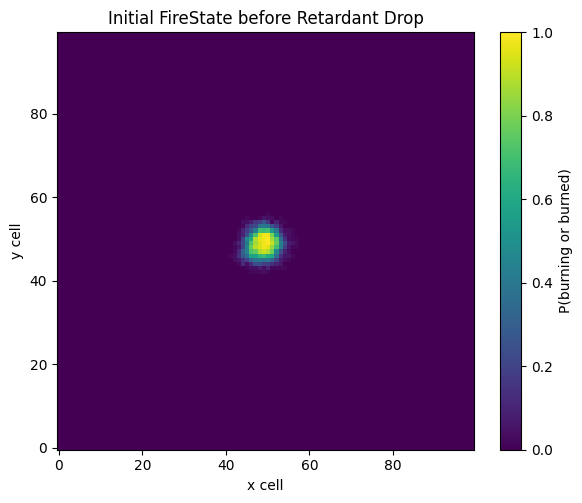

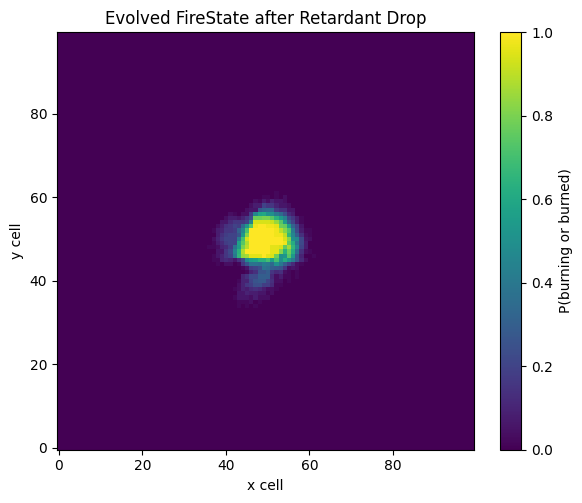

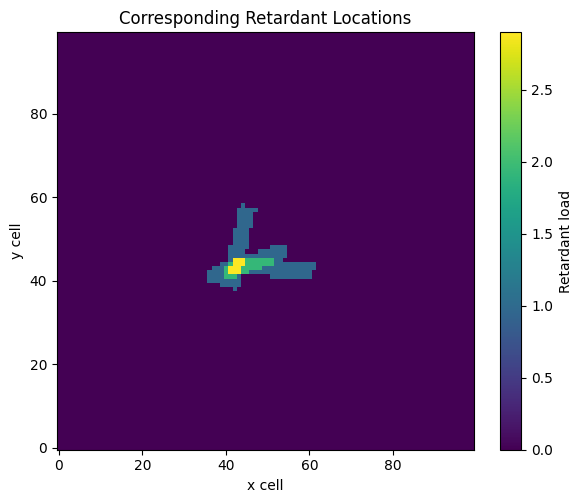

In [11]:
drop_opt.plot_evolved_firestate(
    theta=best_theta,
    n_sims=50,)